<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

Итак, мы получили данные, начнем смотреть их. Поскольку это время, отложим наши привычные методы. Проведем ресемплирование по 1 часу и построим все графики как нас учили на курсе.

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.iolib.table import SimpleTable
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.preprocessing import PowerTransformer, StandardScaler
from lightgbm import LGBMRegressor
from itertools import product
from catboost import CatBoostRegressor
import lightgbm as lgb
from sklearn.pipeline import Pipeline, make_pipeline

<img src="https://emojigraph.org/media/apple/check-mark-button_2705.png" align=left width=33, heigth=33>
<div class="alert alert-success">
Отлично, все нужные библиотеки импортированы в начале ноутбука.Это хорошая практика.</div>

In [2]:
data = pd.read_csv('/datasets/taxi.csv', parse_dates=['datetime'],
                   index_col='datetime')

<img src="https://emojigraph.org/media/apple/check-mark-button_2705.png" align=left width=33, heigth=33>
<div class="alert alert-success">
 👍 Отлично, при загрузке сразу обрабатываются даты</div>

In [3]:
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [5]:
if not data.index.is_monotonic:
    data = data.sort_index()
    
data = data.resample('1H').sum()

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


In [7]:
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


## Анализ

График ресемплированных данных

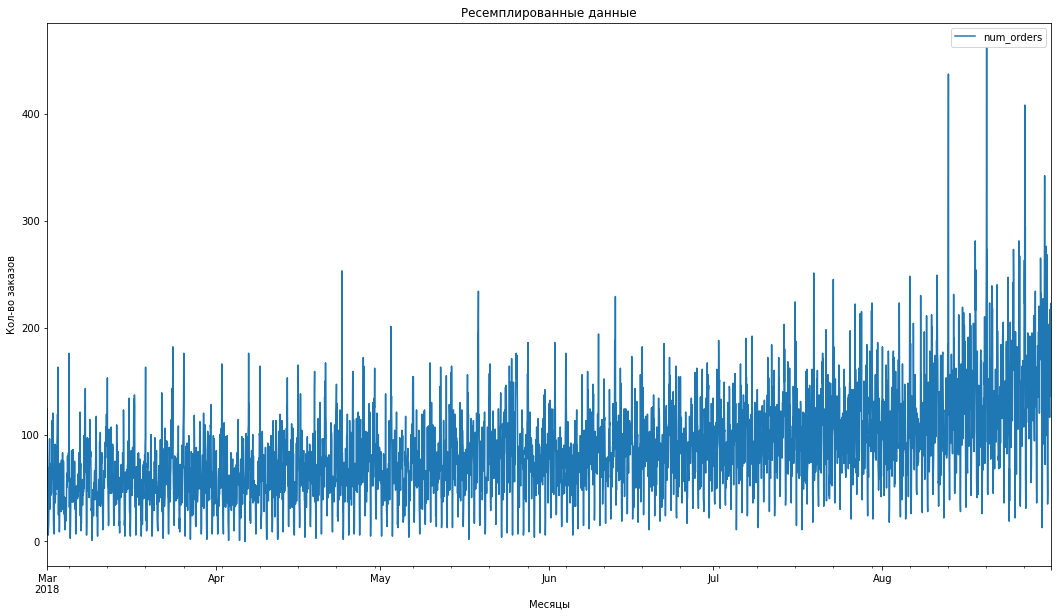

In [8]:
#data = data.resample('1H').sum()
figsize = (18,10)
data.plot(figsize=figsize)
plt.title('Ресемплированные данные')
plt.xlabel('Месяцы')
plt.ylabel('Кол-во заказов')
plt.show()

Этот код отображает график количества заказов на протяжении всего периода данных в виде временного ряда. График позволяет визуально проанализировать общую динамику количества заказов за все месяцы нашего датасета. Видно, что количество заказов растер.

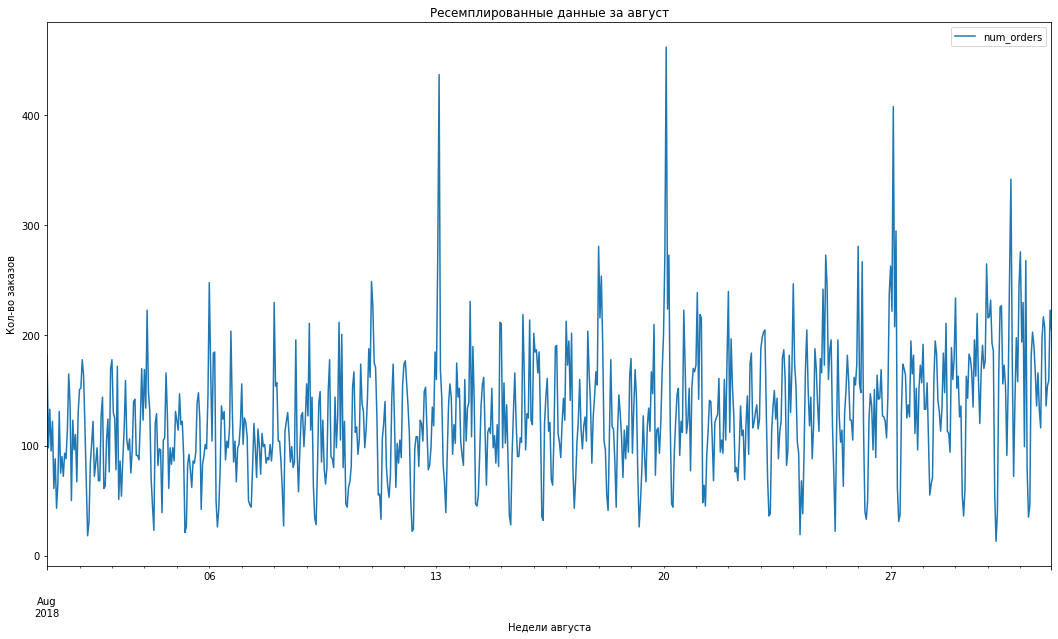

In [9]:
#вывожу график за август:
data_aug = data['2018-08-01':]
data_aug.plot(figsize=figsize)
plt.title('Ресемплированные данные за август')
plt.xlabel('Недели августа')
plt.ylabel('Кол-во заказов')
plt.show()

Это график количества заказов за август, построенный на основе данных, начиная с 1 августа 2018 года. График отображает ежедневное количество заказов в течение месяца августа. А также понять, какие дни могут быть наиболее загруженными или менее активными с точки зрения заказов в течение месяца. На графике видно, что по понедельникам заказов явно больше.И так же мы можем сделать вывод, что день недели важный для нас признак.

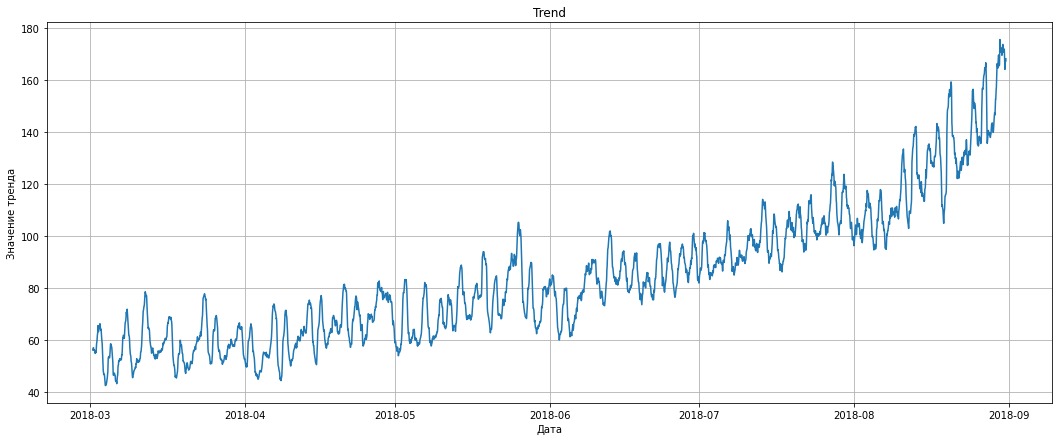

In [10]:
decomposed_data = seasonal_decompose(data)

plt.figure(figsize=(18, 7))
plt.plot(decomposed_data.trend)
plt.title('Trend')
plt.xlabel('Дата')
plt.ylabel('Значение тренда')
plt.grid(True)
plt.show()

График тренда данных, полученных в результате декомпозиции временного ряда. Тренд представляет собой общий долгосрочный характер изменений в данных, который отражает общий уровень роста.
На графике мы видим, как меняется общий тренд данных с течением времени. 

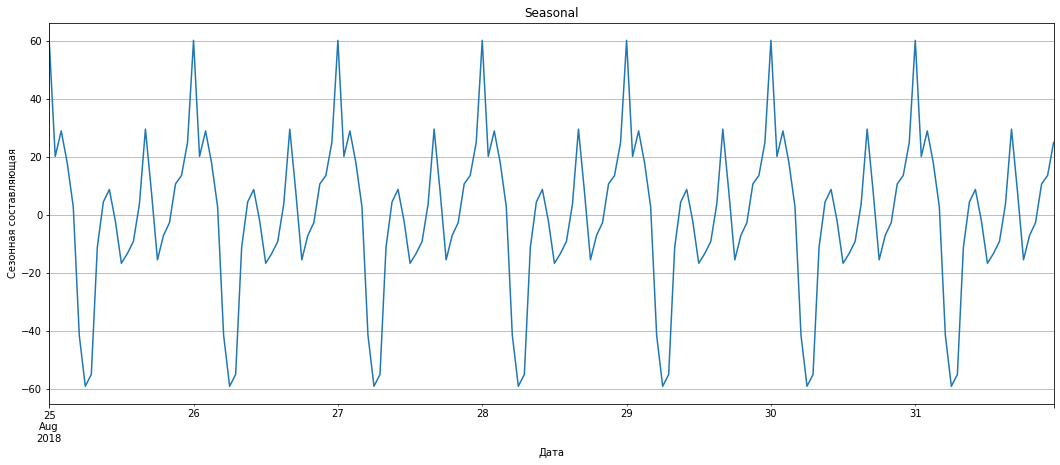

In [11]:
plt.figure(figsize=(18, 7))
decomposed_data.seasonal.tail(24*7).plot(title='Seasonal')
plt.xlabel('Дата')
plt.ylabel('Сезонная составляющая')
plt.grid(True)
plt.show()

Ну что тут можно сказать. Тренд явно восходящий, ситуация меняется по часам и по дням, поэтому на следующем этапе для моделей мы учтем день недели, часы, дник и месяца. Идем дальше. 

## Обучение

Начнем работу с моделями. Сначала добавим фичей. Дальше разделим данные на обучающие, валидационные и тестовые наборы. В качестве моделей будем обучать линейную регрессию, LightGBM и Кэтбуст.

In [12]:
def make_features(data, max_lag, rolling_mean_size):
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
#    data['day'] = data.index.day
#    data['month'] = data.index.month
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    
    return data

In [14]:
# Предположим, что data_with_features уже отсортирован по дате
data_with_features = make_features(data, max_lag=24, rolling_mean_size=2)

# Удалим строки с пропущенными значениями
data_with_features.dropna(inplace=True)

# Разделяем данные на обучающий и тестовый наборы
X = data_with_features.drop('num_orders', axis=1)
y = data_with_features['num_orders']

# Вычисляем индекс, который отделит последние 10% данных
test_index = int(len(X) * 0.9)

# Разделение на обучающий и тестовый наборы (90% на обучающий, 10% на тестовый)
X_train, X_test = X[:test_index], X[test_index:]
y_train, y_test = y[:test_index], y[test_index:]

# Проверим размеры полученных наборов данных
print("Размер обучающего набора:", X_train.shape[0])
print("Размер тестового набора:", X_test.shape[0])

Размер обучающего набора: 3952
Размер тестового набора: 440


In [17]:
model = LinearRegression()
scaler = StandardScaler()
pipeline = make_pipeline(scaler, model)
param_grid = {
    "linearregression__fit_intercept": [True, False],
    "linearregression__normalize": [True, False]
}
grid_search_lr = GridSearchCV(pipeline, param_grid, scoring='neg_mean_squared_error', cv=5)
grid_search_lr.fit(X_train, y_train)
cv_rmse = np.sqrt(-grid_search_lr.best_score_)
print("Среднеквадратичная ошибка (RMSE) на обучающем наборе с использованием кросс-валидации после шкалирования:", cv_rmse)

Среднеквадратичная ошибка (RMSE) на обучающем наборе с использованием кросс-валидации после шкалирования: 26.190778607618896


In [19]:
model = lgb.LGBMRegressor()
param_grid = {
    'num_leaves': [20, 30, 40],
    'learning_rate': [0.1, 0.05, 0.01],
    'n_estimators': [100, 200, 300]
}
grid_search_lgb = GridSearchCV(model, param_grid, scoring='neg_mean_squared_error', cv=5)
grid_search_lgb.fit(X_train, y_train)
best_params = grid_search_lgb.best_params_
print("Лучшие параметры модели LightGBM:", best_params)
predictions_train = grid_search_lgb.predict(X_train)
rmse_train = np.sqrt(mean_squared_error(y_train, predictions_train))
print("Среднеквадратичная ошибка корня (RMSE) на обучающем наборе для LightGBM с лучшими параметрами:", rmse_train)

Лучшие параметры модели LightGBM: {'learning_rate': 0.05, 'n_estimators': 200, 'num_leaves': 20}
Среднеквадратичная ошибка корня (RMSE) на обучающем наборе для LightGBM с лучшими параметрами: 14.87286655423817


In [20]:
model_catboost = CatBoostRegressor(verbose=0)
param_grid_catboost = {
    'depth': [4, 6, 8],
    'learning_rate': [0.1, 0.05, 0.01],
    'n_estimators': [100, 200, 300]
}
grid_search_catboost = GridSearchCV(model_catboost, param_grid_catboost,
                                    scoring='neg_mean_squared_error', cv=5, verbose=0)

grid_search_catboost.fit(X_train, y_train)
best_model_idx = grid_search_catboost.best_index_
best_params = grid_search_catboost.best_params_
best_rmse = np.sqrt(-grid_search_catboost.best_score_)

print("Лучшие параметры модели CatBoost:", best_params)
print("RMSE лучшей модели:", best_rmse)

Лучшие параметры модели CatBoost: {'depth': 4, 'learning_rate': 0.1, 'n_estimators': 300}
RMSE лучшей модели: 23.403266270070013


Обучили. Все наши модели справились и дали метрику на валидационных данных не больше 48. Теперь протестируем и выберем лучшую.

Выводы пункт 3. 

1. Мы разделили данные на тренировочную и тестоую выборки.   
Размер обучающего набора: 3952  
Размер тестового набора: 440  
2. Обучили три модели. Использовали GridSearchCV  для подбора гипперпараметров. Получили слудющие метрики. ,

* Линейная регрессия (RMSE) на обучающем наборе с использованием кросс-валидации после шкалирования: 26.190778607618896
* RMSE на обучающем наборе для LightGBM с лучшими параметрами: 14.87286655423817
* RMSE лучшей модели  CatBoost: 23.403266270070013

Для дальнейшей работы выбрали LightGBM, на следующем этапе применим модель с найденными гипперпараметрами к тестовой выборке. Посмотрим результат.

## Тестирование

In [23]:
predictions_test = grid_search_lgb.predict(X_test)
rmse_test = np.sqrt(mean_squared_error(y_test, predictions_test))
print("RMSE для LightGBM на тесте:", rmse_test)

RMSE для LightGBM на тесте: 40.48039598392909


Итак, мы получили метрику RMSE для LightGBM на тесте: 40.4803 По условию задачи, нужно получить не более 48. 

# Общие выводы. 

1. На первом шаге, мы в первой ячейке добавили необходимые импорты. Открыли файл с данными. Посмотрели что за данные, командой info и head. Провели ресеплирование данных.

2. На втором шаге провели анализ данных. Построили несколько графиков, выявили тренд. Посмотрели сезонность. 

3. Приступили к обучению моделей. Сначала выделили признаки для модели. День недели и часы. Затем разделили на тренировочную и тестовую выборки. Причем в этом проекте на тестовы денные мы взяли 10% от всего датасета. Данные за последнее время. Обучили три модели. Использовали GridSearchCV для подбора гипперпараметров. Получили слудющие метрики.
* Линейная регрессия (RMSE) на обучающем наборе с использованием кросс-валидации после шкалирования: 26.190778607618896
* RMSE на обучающем наборе для LightGBM с лучшими параметрами: 14.87286655423817
* RMSE лучшей модели CatBoost: 23.403266270070013
Для дальнейшей работы выбрали LightGBM, на следующем этапе применим модель с найденными гипперпараметрами к тестовой выборке.

4. На последнем этапе проверили модель на тесте. Получили метрику RMSE 40. 




## Чек-лист проверки

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Данные загружены и подготовлены
- [x]  Данные проанализированы
- [x]  Модель обучена, гиперпараметры подобраны
- [x]  Качество моделей проверено, выводы сделаны
- [x]  Значение *RMSE* на тестовой выборке не больше 48